In [356]:
import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from statistics import mean
import torch
from torchvision.transforms import v2 as T
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

NUM_VIEWS_PER_SCENE = 6
TOD_filepath = 'C:/dataset/TOD/training_set/'
# scenes_names = sorted(os.listdir(TOD_filepath))
# scenes_paths = [TOD_filepath+j for j in scenes_names]

# Dataset

In [357]:
# Visualization & Ploting Functions

def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    from matplotlib.patches import Polygon

    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_bbox_and_mask(rgb_img, bbox, mask_img):
    seg_img=visualize_segmentation(rgb_img,mask_img)
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(1, 3, 1) 
    plt.imshow(rgb_img)
    for box in bbox:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(1, 3, 2) 
    plt.imshow(mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(1, 3, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")
    plt.show()

In [358]:
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image
def get_bounding_boxes(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    boxes = masks_to_boxes(masks).detach().numpy()
    if boxes.all()==None:
        boxes=np.array([])
    return boxes

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """
    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor

In [359]:
NUM_VIEWS_PER_SCENE=6
scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))[:3]
for idx in range(18):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx%NUM_VIEWS_PER_SCENE)+1
    print(scene_idx, view_num)

0 1
0 2
0 3
0 4
0 5
0 6
1 1
1 2
1 3
1 4
1 5
1 6
2 1
2 2
2 3
2 4
2 5
2 6


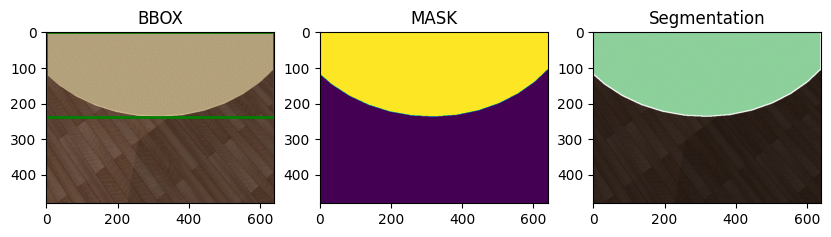

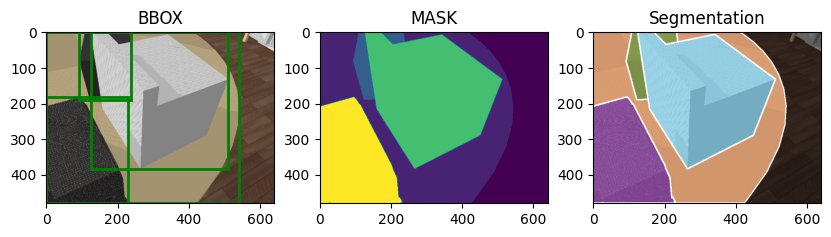

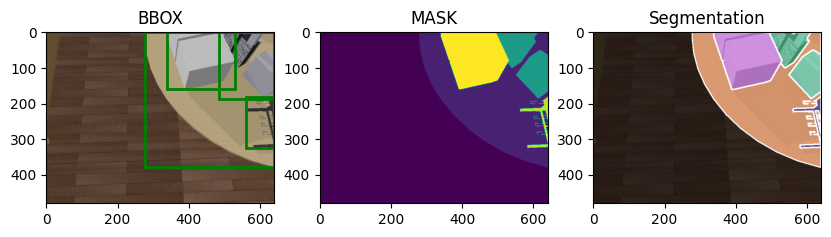

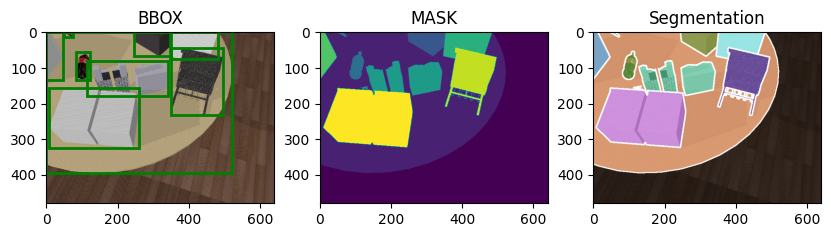

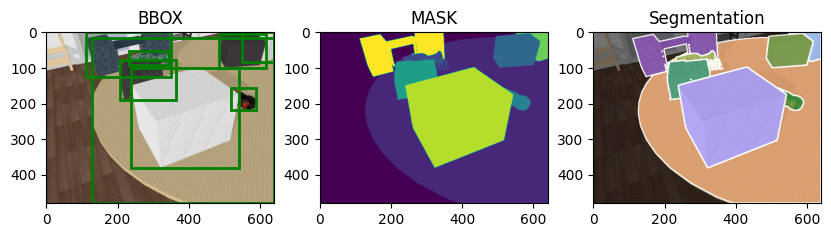

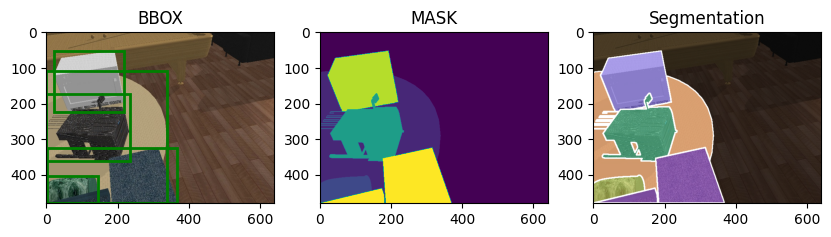

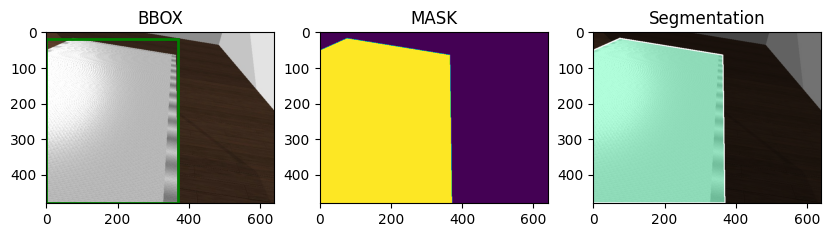

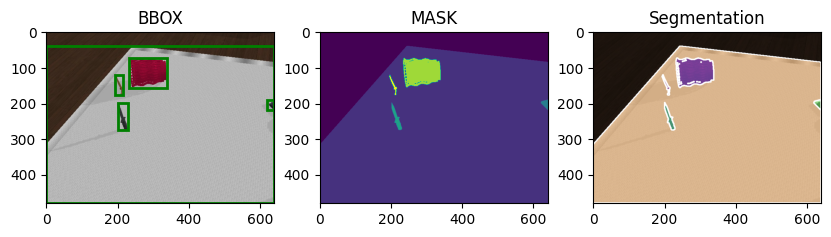

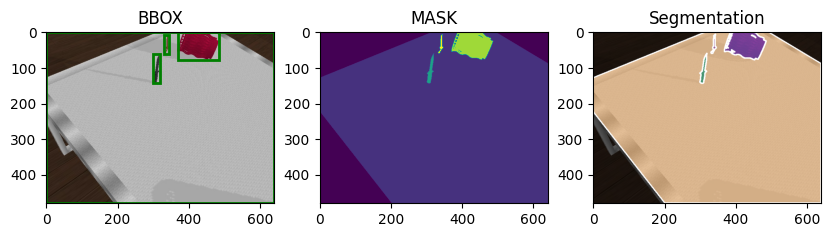

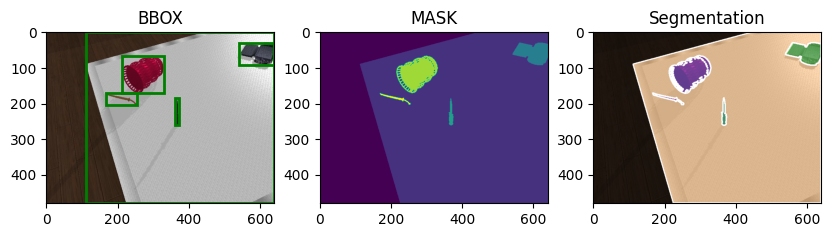

In [361]:
scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))
for idx in range(10):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx % NUM_VIEWS_PER_SCENE)+1

    # RGB image
    rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
    rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # Shape: (H, W, C)

    # Mask
    mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
    im = Image.open(mask_filename)
    gt_mask_img = np.array(im) # Shape: (H, W) 

    # Bounding Box
    bbox_points = get_bounding_boxes(read_image(mask_filename)) # Shape: (N, 4) xmin, ymin, xmax, ymax
    
    show_bbox_and_mask(rgb_img, bbox_points,gt_mask_img)
    # print(rgb_img.shape, gt_mask_img.shape, bbox_points.shape)

    # Numpy 2 Tensor
    # rgb_img     = array_to_tensor(rgb_img)      # (C, H, W) torch.tensor(rgb_img).permute(2,0,1).float()
    # gt_mask_img = array_to_tensor(gt_mask_img)  # (H, W)    torch.tensor(gt_mask_img[None, :,:]).float()
    # bbox_points = array_to_tensor(bbox_points)  # (N, 4)    torch.tensor(bbox_points).int()
    # print(rgb_img.shape, gt_mask_img.shape, bbox_points.shape)
    # print(rgb_img, gt_mask_img, bbox_points)
    

In [397]:
# https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/4a542c9f39bedbfe7de5061767181d36/torchvision_tutorial.ipynb#scrollTo=JJCznPo-Ws3U

# def get_transform(train):
#     transforms = []
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     transforms.append(T.ToDtype(torch.float, scale=True))
#     transforms.append(T.ToPureTensor())
#     return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir, transform):
        self.base_dir = base_dir
        self.transforms = transforms
        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))[:10] # Giving no of Folders to consider

    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me
    
        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = (idx % NUM_VIEWS_PER_SCENE)+1
        
        # Approach 1 (UOIS UTD)
        # RGB image
        rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # (480, 640, 3)

        # Mask
        mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        im = Image.open(mask_filename)
        gt_mask_img = np.array(im) # (480, 640) 

        # Bounding Box
        bbox_points = get_bounding_boxes(read_image(mask_filename)) # Shape: (N, 4) xmin, ymin, xmax, ymax
        
        # Numpy 2 Tensor
        # rgb_img     = array_to_tensor(rgb_img)      # Shape: (3, 480, 640) torch.tensor(rgb_img).permute(2,0,1).float()
        # gt_mask_img = array_to_tensor(gt_mask_img)  # Shape: (480, 640)    torch.tensor(gt_mask_img[None, :,:]).float()
        # bbox_points = array_to_tensor(bbox_points)  # Shape: (N, 4)    torch.tensor(bbox_points).int()
        if self.transform:
            # rgb_img = self.transform(rgb_img)         # Shape: (3, 224, 224)
            # gt_mask_img = self.transform(gt_mask_img) # Shape: (224, 224)
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            rgb_img = sam_trans.apply_image_torch(rgb_img)                                              # Shape: ()
            gt_mask_img = sam_trans.apply_image_torch(gt_mask_img)                                      # Shape: ()
            box = sam_trans.apply_boxes(bbox_points, (gt_mask_img.shape[-2], gt_mask_img.shape[-1]))    # Shape: ()
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)                          # Shape: ()
            bbox_points = box_torch

        return rgb_img, gt_mask_img, bbox_points

        # # Approach 2 (Colab one) !!! Issue: tv tensors convert Image into Image tensor which is not converted to torch for rehsaping
        # # load images and masks
        # rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
        # mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
        # img = read_image(rgb_img_filename)
        # mask = read_image(mask_filename)

        # # instances are encoded as different colors
        # obj_ids = torch.unique(mask)
        # # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        # num_objs = len(obj_ids)
        # # split the color-encoded mask into a set
        # # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        # # get bounding box coordinates for each mask
        # boxes = masks_to_boxes(masks)

        # # Wrap sample and targets into torchvision tv_tensors:
        # img = tv_tensors.Image(img)                                                         # Shape: (3, 480, 640) 
        # boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)) # Shape: (N, 4)
        # gtmasks = tv_tensors.Mask(mask)                                                     # Shape: (1, 480, 640)  

        # return img, gtmasks, boxes

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to the size a model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization values for pre-trained PyTorch models
])
    
dataset = Tabletop_Object_Dataset(TOD_filepath, transform=transform)
dl = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)
# dataset = Tabletop_Object_Dataset(TOD_filepath, get_transform(train=True))
# dl = DataLoader(dataset=dataset, batch_size=4, shuffle=True, worker_init_fn=worker_init_fn)

In [398]:
dataset.__len__(), len(dl)

(60, 60)

 RGB: (B, 3, 480, 640)

MASK: (B, 1, 480, 640)

BBOX: (1, N, 4)


In [399]:
DATA=[]
for images, masks, boxes in dl:
    # images = torch.tensor(np.array([array_to_tensor(image) for image in images])) # Reshaping: (480, 640, 3) -> (2, 3, 480, 640)
    # masks = torch.tensor(np.array([array_to_tensor(mask) for mask in masks])) # Reshaping: (480, 640) -> (2, 480, 640)
    # boxes = [box for box in boxes]   # Reshaping: (N, 4) -> (2, N, 4)  !!! ERROR CANNoT put N so need to use only "1 sample per batch"
    
    images = torch.tensor(np.array([array_to_tensor(images[0])])) # Reshaping: (480, 640, 3) -> (1, 3, 480, 640)
    masks = torch.tensor(np.array([array_to_tensor(masks[0])])) # Reshaping: (480, 640) -> (1, 480, 640)
    boxes = np.array(boxes) # Reshaping: (N, 4) -> (1, N, 4) where, N is no of boxes
    # print(images.shape, masks.shape, boxes.shape)
    # tuple with shapes ((B, 3, 480, 640),(B, 480, 640),(B, N, 4))
    DATA.append((images,masks,boxes))
len(DATA)

60

In [385]:
# for images, masks, boxes in dl:
#     # images = np.array([image for image in images])
#     # targets = [{k: v for k, v in t.items()} for t in targets]
#     print(len(images),len(masks),len(boxes))
#     print(type(images),type(masks),type(boxes))
#     print(images[0].shape, masks[0].shape, boxes[0].shape)
#     print(images[1].shape, masks[1].shape, boxes[1].shape)
#     # print("-------------------------------------------------------")
#     # print(torch.tensor(list(image for image in images)).shape,torch.tensor(list(mask for mask in masks)).shape,torch.tensor(boxes).shape)
#     break


# # for rgb, gtmask, bb in dl:
# #     print(len(rgb),len(gtmask),len(bb)) 
# #     print(rgb[0].shape)
# #     print(array_to_tensor(np.array([rgb[0]])).shape)
# #     break

In [252]:
# data=list()
# for rgb, gtmask, bb in dl: 
#     # print(array_to_tensor(np.array([rgb[0]])).shape)
#     batch_rgb = array_to_tensor(np.array([rgb[0]])) # [0] used bcoz only 1 Batch
#     batch_mask = array_to_tensor(np.array([gtmask[0]])) # [0] used bcoz only 1 Batch
#     batch_mask = bb[0]

#     # Issue with below is rgb was in np and when again converted to torch shape is rgb.shape: torch.Size([1, 640, 3, 480])
#     # batch_rgb = np.array([r for r in rgb]) # (B, 3, 480, 640)
#     # batch_mask = np.array([g for g in gtmask]) # (B, 480, 640)
#     # batch_bbox = bb[0] # [(N,4)]*B  || if B=1 then [N,4] where N = no. of bboxes
#     # data.append((batch_rgb,batch_mask,batch_bbox))
#     # # print(batch_rgb.shape, batch_mask.shape, len(batch_bbox))
#     # # print(f"{rgb[0].shape} \t {gtmask[0].shape} \t {bb[0].shape}")
#     # # print(f"{rgb[1].shape} \t {gtmask[1].shape} \t {bb[1].shape}")
# len(data)

torch.Size([1, 640, 3, 480])


0

# Fine Tune SAM

In [408]:
# Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [409]:
# https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/finetune_and_inference_tutorial_2D_dataset.ipynb
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "model"

sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
count_parameters(sam_model)
sam_model.train()
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

+-----------------------------------------------------------------------------+------------+
|                                   Modules                                   | Parameters |
+-----------------------------------------------------------------------------+------------+
|                           image_encoder.pos_embed                           |  3145728   |
|                    image_encoder.patch_embed.proj.weight                    |   589824   |
|                     image_encoder.patch_embed.proj.bias                     |    768     |
|                     image_encoder.blocks.0.norm1.weight                     |    768     |
|                      image_encoder.blocks.0.norm1.bias                      |    768     |
|                    image_encoder.blocks.0.attn.rel_pos_h                    |    1728    |
|                    image_encoder.blocks.0.attn.rel_pos_w                    |    1728    |
|                    image_encoder.blocks.0.attn.qkv.weight           

In [410]:
for name, param in sam_model.named_parameters():
  if name.startswith("image_encoder") or name.startswith("mask_decoder"):
    param.requires_grad_(False)

In [411]:
count_parameters(sam_model)

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| prompt_encoder.point_embeddings.0.weight |    256     |
| prompt_encoder.point_embeddings.1.weight |    256     |
| prompt_encoder.point_embeddings.2.weight |    256     |
| prompt_encoder.point_embeddings.3.weight |    256     |
| prompt_encoder.not_a_point_embed.weight  |    256     |
| prompt_encoder.mask_downscaling.0.weight |     16     |
|  prompt_encoder.mask_downscaling.0.bias  |     4      |
| prompt_encoder.mask_downscaling.1.weight |     4      |
|  prompt_encoder.mask_downscaling.1.bias  |     4      |
| prompt_encoder.mask_downscaling.3.weight |    256     |
|  prompt_encoder.mask_downscaling.3.bias  |     16     |
| prompt_encoder.mask_downscaling.4.weight |     16     |
|  prompt_encoder.mask_downscaling.4.bias  |     16     |
| prompt_encoder.mask_downscaling.6.weight |    4096    |
|  prompt_enco

6220

0: rgb.shape=torch.Size([1, 3, 480, 640]), gtmask.shape=torch.Size([1, 480, 640]), boxes.shape=(1, 4, 4)
BEFORE 0: rgb.shape=torch.Size([1, 3, 480, 640]), gtmask.shape=torch.Size([1, 480, 640]), boxes.shape=(1, 4, 4)
 AFTER 0: rgb.shape=torch.Size([1, 3, 768, 1024]), gtmask.shape=torch.Size([1, 480, 640]), boxes.shape=(1, 4, 4)


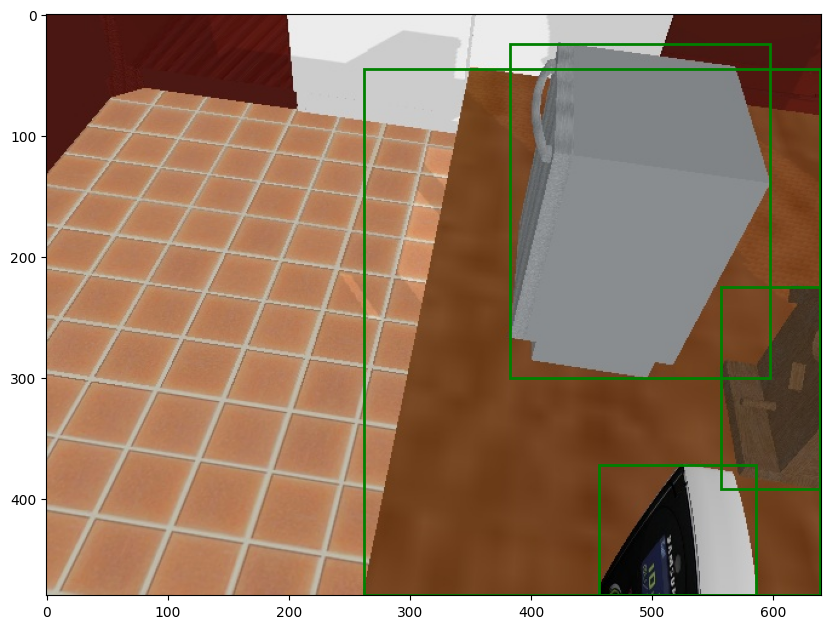

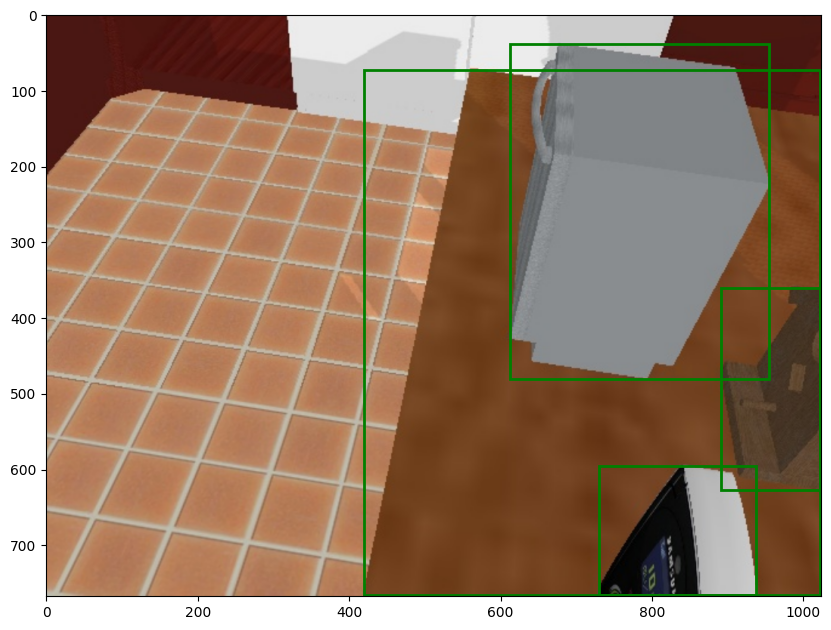

In [444]:
for step, (rgb, gtmask, boxes) in enumerate(DATA):
    # print(type(rgb),type(gtmask),type(boxes))
    print(f"{step}: {rgb.shape=}, {gtmask.shape=}, {boxes.shape=}") 
    
    # BEFORE SCALING 
    img_og = rgb.permute(0, 2, 3, 1)[0].numpy()
    fig = plt.figure(figsize=(10, 10))     
    fig.add_subplot(1, 1, 1) 
    plt.imshow(img_og.astype('uint8'))
    for b in boxes[0]:
        show_box(b, plt.gca())
    plt.axis('on')
    print(f"BEFORE {step}: {rgb.shape=}, {gtmask.shape=}, {boxes.shape=}") 

    sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
    rgb = sam_trans.apply_image_torch(rgb)
    box = sam_trans.apply_boxes(boxes, (gtmask.shape[-2], gtmask.shape[-1]))
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

    # AFTER SCALING
    img = rgb.permute(0, 2, 3, 1)[0].numpy()

    fig = plt.figure(figsize=(10, 10))     
    fig.add_subplot(1, 1, 1) 
    plt.imshow(img.astype('uint8'))
    for b in box:
        show_box(b, plt.gca())
    plt.axis('on')
    print(f" AFTER {step}: {rgb.shape=}, {gtmask.shape=}, {boxes.shape=}") 
    # sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
    #     points=None,
    #     boxes=box_torch,
    #     masks=None,
    # )
    # print(sparse_embeddings.shape, dense_embeddings.shape)
    # mask_predictions, _ = sam_model.mask_decoder(
    #     image_embeddings=rgb.to(device), # (B, 3, 480, 640)
    #     image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
    #     sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)    ??
    #     dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64) ??
    #     multimask_output=False,
    # )
    # print(mask_predictions.shape)
    # print(mask_predictions)
    break

In [442]:
for step, (rgb, gtmask, boxes) in enumerate(DATA):
    print(rgb.shape)
    sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
    rgb = sam_trans.apply_image_torch(rgb)
    print(rgb.shape)
    image_embedding = sam_model.image_encoder(rgb.to(device))
    print(image_embedding.shape)
    # prompt_box = bbox_coords[k]
    # box = transform.apply_boxes(prompt_box, original_image_size)
    # box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    # box_torch = box_torch[None, :]

torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 768, 1024])


RuntimeError: The size of tensor a (48) must match the size of tensor b (64) at non-singleton dimension 1

In [ ]:
num_epochs = 1
losses = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    # train
    for step, (rgb, gtmask, boxes) in enumerate(data):
        outputs = model(**inputs, multimask_output=False)

Transformers SAM

In [ ]:
# from transformers import SamModel, SamProcessor

# model = SamModel.from_pretrained("facebook/sam-vit-base")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
# Freeze The Encoder and Decoder 
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("mask_decoder"):
    param.requires_grad_(False)

optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=1e-5)
loss_fn = torch.nn.MSELoss()

num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

In [ ]:
def standardize_image(image):
    """ Convert a numpy.ndarray [H x W x 3] of images to [0,1] range, and then standardizes

        @return: a [H x W x 3] numpy array of np.float32
    """
    image_standardized = np.zeros_like(image).astype(np.float32)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(3):
        image_standardized[...,i] = (image[...,i]/255. - mean[i]) / std[i]

    return image_standardized


In [ ]:
def process_rgb(img):
    rgb_img = rgb_img.astype(np.float32)
    rgb_img = standardize_image(rgb_img)
    return rgb_img

def process_mask(img):
    pass

def process_bbox(bbox):
    pass

for epoch in tqdm(range(num_epochs), des='EPOCH '):
    epoch_losses=[]
    for i, sample in enumerate(TRAINING_DATASET):
        # print(sample['rgb_img'].shape, sample['mask_img'].shape, sample['bbox'].shape)
        
        # np -> tensor
        rgb_img = process_rgb(sample['rgb_img']) # Shape
        mask_img = process_mask(sample['mask_img']) # Shape 
        bbox = process_bbox(sample['bbox']).to(device) # Shape || (torch.FloatTensor of shape (batch_size, num_boxes, 4))
        
        # Forward Pass
        outputs = model(
            input_boxes=bbox.to(device),
            multimask_output=False
        )
        # Compute Loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        loss = loss_fn(predicted_masks, mask_img.float().to(device).unsqueeze(1))
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        # Optimize 
        optimizer.step()
        epoch_losses.append(loss.item())
        print(f'EPOCH {epoch} \t Mean Loss: {mean(epoch_losses)}')

In [ ]:
import torch

def convert_ground_truth_to_model_mask(ground_truth_mask, num_objects):
    """
    Convert a ground truth mask with combined objects into separate object masks.

    Parameters:
    ground_truth_mask (torch.Tensor): Ground truth mask with shape (1, 480, 640).
    num_objects (int): Number of objects to separate.

    Returns:
    torch.Tensor: Model training masks with shape (num_objects, 1, 480, 640).
    """
    # Initialize the tensor to hold individual masks
    individual_masks = torch.zeros((num_objects, 1, 480, 640), dtype=torch.float32)
    
    # Iterate over each object label
    for obj in range(1, num_objects + 1):
        individual_masks[obj - 1, 0] = (ground_truth_mask == obj).float()
    
    return individual_masks

scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))

for idx in range(16,17):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx % NUM_VIEWS_PER_SCENE)+1
    
    # RGB image
    rgb_img_filename = scene_dir + f"rgb_{view_num:05d}.jpeg"
    rgb_img = cv2.cvtColor(cv2.imread(rgb_img_filename), cv2.COLOR_BGR2RGB) # (480, 640, 3)

    # Mask
    mask_filename = scene_dir + f"segmentation_{view_num:05d}.png"
    im = Image.open(mask_filename)
    gt_mask_img = np.array(im) # (480, 640) 

    # Bounding Box
    bbox_points = get_bounding_boxes(read_image(mask_filename)) # Shape: (N, 4) xmin, ymin, xmax, ymax
    
    gt = torch.tensor(np.array([gt_mask_img]))
    gtmask = np.array(convert_ground_truth_to_model_mask(gt, bbox_points.shape[0]))
    print(gtmask.shape)
    
    # print(bbox_points)
    seg_img=visualize_segmentation(rgb_img,gt_mask_img)
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(2, 4, 1) 
    plt.imshow(rgb_img)
    for box in bbox_points:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(2, 4, 2) 
    plt.imshow(gt_mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(2, 4, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")

    fig.add_subplot(2, 4, 4) 
    plt.imshow(gtmask[0][0])
    plt.axis('on')
    plt.title("0??")

    fig.add_subplot(2, 4, 5) 
    plt.imshow(gtmask[1][0])
    plt.axis('on')
    plt.title("1??")

    fig.add_subplot(2, 4, 6) 
    plt.imshow(gtmask[2][0])
    plt.axis('on')
    plt.title("2??")

    fig.add_subplot(2, 4, 7) 
    plt.imshow(gtmask[3][0])
    plt.axis('on')
    plt.title("3??")

    fig.add_subplot(2, 4, 8) 
    plt.imshow(gtmask[4][0])
    plt.axis('on')
    plt.title("4??")
    plt.show()